In [1]:
import gymnasium as gym
from adaptive_time.features import Fourier_Features
import numpy as np

import matplotlib.pyplot as plt
import random
import adaptive_time.utils

In [2]:
seed = 13

In [3]:
gym.register(
    id="CartPole-OURS-v0",
    entry_point="adaptive_time.environments.cartpole:CartPoleEnv",
    vector_entry_point="adaptive_time.environments.cartpole:CartPoleVectorEnv",
    max_episode_steps=500,
    reward_threshold=475.0,
)

In [4]:
def reset_randomness(seed, env):
    random.seed(seed)
    np.random.seed(seed)
    # env.seed(seed)
    env.action_space.seed(seed)


In [5]:
env = gym.make('CartPole-OURS-v0')
tau = 0.02
env.stepTime(tau)


def generate_trajectory(env, policy=None):
    observation, _ = env.reset()
    trajectory = []
    terminated = False
    if policy is None:
        policy = lambda x: env.action_space.sample()
    while not terminated:
        action = policy(observation)
        observation_, reward, terminated, truncated, info = env.step(action)
        trajectory.append([observation, action, reward, observation_])
        observation = observation_

    return trajectory


In [6]:

reset_randomness(seed, env)
trajectory = generate_trajectory(env)

In [8]:
print(len(trajectory))
print(trajectory[0])

# seed = 13 should be:
# 16
# [array([0., 0., 0., 0.], dtype=float32), 1, 1.0, array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32)]

16
[array([0., 0., 0., 0.], dtype=float32), 1, 1.0, array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32)]


In [13]:
phi = Fourier_Features()
phi.init_fourier_features(4,3)
phi.init_state_normalizers(np.array([4.8,2.0,0.418,1]), np.array([-4.8,-2.0,-0.418,-1]))

In [14]:
phi.num_parameters

256

In [45]:


def ols_monte_carlo(env, phi, weights, targets, features, x0, gamma = 0.999):
    trajectory = generate_trajectory(env)
    N = len(trajectory)
    G = 0
    returns = []  # from x0 (the initial state)
    for t in range(N-1,-1,-1):
        state, _, reward, _ = trajectory[t]
        G = gamma*G + reward
        x = phi.get_fourier_feature(state)
        if np.linalg.norm(x-x0) < 0.00001:
            returns.append(G)
        features += np.outer(x,x)
        targets += G * x
    weights = np.linalg.solve(features, targets)
    return weights, targets, features, np.mean(returns)


def gradient_monte_carlo(env, phi, weights, x0, gamma = 1, alpha = 0.001):
    trajectory = generate_trajectory(env)
    N = len(trajectory)
    G = 0
    returns = []
    for t in range(N-1,-1,-1):
        state, _, reward, _ = trajectory[t]
        G = gamma * G + reward
        x = phi.get_fourier_feature(state)
        if np.linalg.norm(x-x0) < 0.00001:
            returns.append(G)
        weights = weights + alpha * (G - np.inner(x, weights)) * x 
    return weights, np.mean(returns)




num_episodes = 1000
returns = []
average_returns = []
predicted_returns = []

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.zeros((d,d))   # An estimate of A = xx^T
targets = np.zeros(d)  # An estimate of b = xG
weights = np.zeros(d)   # The weights that approximate A^{-1} b
x = phi.get_fourier_feature([0,0,0,0])  # the initial state
for episode in range(num_episodes):
    weights, targets, features, cur_avr_returns = ols_monte_carlo(
        env, phi, weights, targets, features, x)
    if cur_avr_returns:
        # When we are starting from the fixed initial state, this
        # should always be true!
        returns.append(cur_avr_returns)
    if returns:
        average_returns.append(np.mean(returns))
        pred_return = np.inner(x, weights)
        predicted_returns.append(pred_return)
        print(
            'episode:', episode,
            ' empirical returns:' , np.mean(returns),
            ' predicted returns:' , pred_return)

episode: 0  empirical returns: 15.880558184360002  predicted returns: 15.880053898658458
episode: 1  empirical returns: 16.372617905267823  predicted returns: 16.37085343810557
episode: 2  empirical returns: 18.8237497423018  predicted returns: 18.804552978650072
episode: 3  empirical returns: 24.40540453558862  predicted returns: 29.417250149762467
episode: 4  empirical returns: 22.306196228670693  predicted returns: 27.50202033080228
episode: 5  empirical returns: 22.705544757717806  predicted returns: 25.64576184345458
episode: 6  empirical returns: 21.730546675809553  predicted returns: 24.8604522422145
episode: 7  empirical returns: 21.36797398328347  predicted returns: 24.520823046350756
episode: 8  empirical returns: 20.8676077213826  predicted returns: 24.028554748511098
episode: 9  empirical returns: 20.859979352773827  predicted returns: 22.79251206203344
episode: 10  empirical returns: 21.03168688238969  predicted returns: 22.453198600902795
episode: 11  empirical returns: 2

In [19]:
def plot_est_vs_pred(tuples_of_y_and_labels_and_kwargs, title=None, show=True):

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for y, label, kwargs in tuples_of_y_and_labels_and_kwargs:
        plt.plot(y, label=label, **kwargs)

    # if ylim:
    #     plt.ylim(-0.05, 0.5)
    # ax.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    # plt.xlim(-1000, 80_000)

    plt.ylabel('Episode\nReturn', rotation=0, labelpad=40)
    plt.xlabel('Number of Episodes')
    plt.legend()

    if title is not None:
      plt.title(title)

    if show:
      plt.show()
    return ax


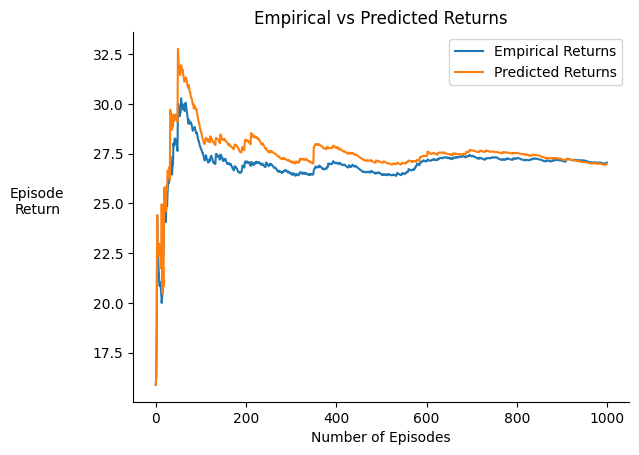

<Axes: title={'center': 'Empirical vs Predicted Returns'}, xlabel='Number of Episodes', ylabel='Episode\nReturn'>

In [20]:

plot_est_vs_pred([
   (average_returns, 'Empirical Returns', {}),
   (predicted_returns, 'Predicted Returns', {})],
   title='Empirical vs Predicted Returns')


## Q-function estimation

Like above, but now learn per-action returns. The strategy is the same, but instead of using `v(s) = phi(s)' w`, we use `q(s, a) = phi(s, a)' w`.

We'll use `phi(s, a) = [ 1_{a=0}*phi(s), 1_{a=1}*phi(s) ]`, so basically each action gets its own weights.

In [38]:
def phi_sa(phi_x, a, prev_phi_sa=None):
    """Form the (state, action) feature, potentially reusing memory.
    
    - phi_x: the state feature
    - a: the action
    - prev_phi_sa: the previous state,action feature, which can be
      reused to avoid memory allocation.

    Returns the feature as a (2, d) array. Use a flat copy.
    """
    if prev_phi_sa is not None:
        prev_phi_sa.fill(0)
        phi_sa = prev_phi_sa
    else:
        phi_sa = np.zeros((2, phi_x.size))
    phi_sa[a] = phi_x
    return phi_sa


def ols_monte_carlo_q(
        env, phi, weights, targets, features, x0, policy=None, print_trajectory=False, gamma = 0.999):
    trajectory = generate_trajectory(env, policy=policy)
    if print_trajectory:
        print("trajectory-len: ", len(trajectory), "; trajectory:")
        for idx, (o, a, r, o_) in enumerate(trajectory):
            # * ignore reward, as it is always the same here.
            # * o_ is the same as the next o.
            print(f"* {idx:4d}: o: {o}\n\t --> action: {a}")
    N = len(trajectory)
    G = 0
    x_sa = np.zeros((2, phi.num_parameters))
    returns_a0 = []  # from x0 (the initial state), action 0
    returns_a1 = []  # from x0 (the initial state), action 1
    for t in range(N-1,-1,-1):
        state, action, reward, _ = trajectory[t]
        G = gamma*G + reward
        x = phi.get_fourier_feature(state)
        # Record empirical returns.
        if np.linalg.norm(x-x0) < 0.00001:
            if action == 0:
                returns_a0.append(G)
                returns_a1.append(-0.000001)
            elif action == 1:
                returns_a1.append(G)
                returns_a0.append(-.0000001)

        x_sa = phi_sa(x, action, x_sa)
        x_sa_flat = x_sa.flatten()

        features += np.outer(x_sa_flat, x_sa_flat)
        targets += G * x_sa_flat
    try:
        weights = np.linalg.solve(features, targets)
    except np.linalg.LinAlgError:
        print("Singular matrix in OLS. Using previous weights.")
    return weights, targets, features, (np.mean(returns_a0), np.mean(returns_a1))



### Run Q-function estimation

In [36]:

num_episodes = 1000

# We record:
returns_per_episode_q = np.zeros((2, num_episodes))
average_returns_q = np.zeros((2, num_episodes))  # the cumulative average of the above
predicted_returns_q = np.zeros((2, num_episodes))

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.zeros((2 * d, 2 * d))   # An estimate of A = xx^T
targets = np.zeros(2 * d)  # An estimate of b = xG
weights = np.zeros(2 * d)   # The weights that approximate A^{-1} b

x_0 = phi.get_fourier_feature([0,0,0,0])  # the initial state
x_sa0 = phi_sa(x_0, 0)
x_sa1 = phi_sa(x_0, 1)

for episode in range(num_episodes):
    weights, targets, features, cur_avr_returns = ols_monte_carlo_q(
        env, phi, weights, targets, features, x_0)
    
    # Store the empirical and predicted returns. For any episode, we may
    # or may not have empirical returns for both actions. When we don't have an
    # estimate, `nan` is returned.
    returns_per_episode_q[:, episode] = cur_avr_returns
    average_returns_q[:, episode] = np.nanmean(returns_per_episode_q[:, :episode+1], axis=1)

    predicted_returns_q[0, episode] = np.inner(x_sa0.flatten(), weights)
    predicted_returns_q[1, episode] = np.inner(x_sa1.flatten(), weights)
    print(
        'episode:', episode,
        ' empirical returns:' , average_returns_q[:, episode],
        ' predicted returns:' , predicted_returns_q[:, episode])

episode: 0  empirical returns: [-1.         15.88055818]  predicted returns: [95.68703838 15.88055818]
episode: 1  empirical returns: [-1.         16.37261791]  predicted returns: [28.69729928 16.37261791]
episode: 2  empirical returns: [-1.         18.82374974]  predicted returns: [-327.46869489   18.82374974]
episode: 3  empirical returns: [-1.         24.40540454]  predicted returns: [38.59525655 24.40540471]
episode: 4  empirical returns: [-1.         22.30619623]  predicted returns: [-179.81360834   22.30619624]
episode: 5  empirical returns: [ 3.28371457 18.42183019]  predicted returns: [24.70201522 22.3061949 ]
episode: 6  empirical returns: [ 5.08326366 15.64728302]  predicted returns: [20.29154224 22.30627465]
episode: 7  empirical returns: [ 4.3228557  16.04511828]  predicted returns: [20.29096555 21.72680334]
episode: 8  empirical returns: [ 3.73142729 16.13618043]  predicted returns: [20.29384911 21.03229041]
episode: 9  empirical returns: [ 5.43741696 14.42256239]  predict

KeyboardInterrupt: 

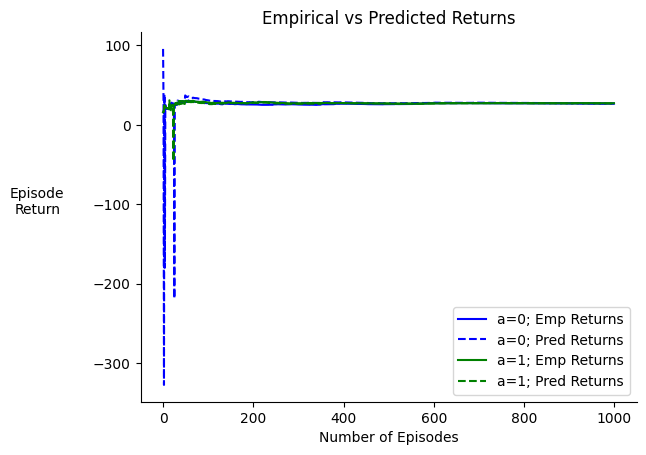

<Axes: title={'center': 'Empirical vs Predicted Returns'}, xlabel='Number of Episodes', ylabel='Episode\nReturn'>

In [27]:

plot_est_vs_pred([
      (average_returns_q[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='Empirical vs Predicted Returns',
   show=True)



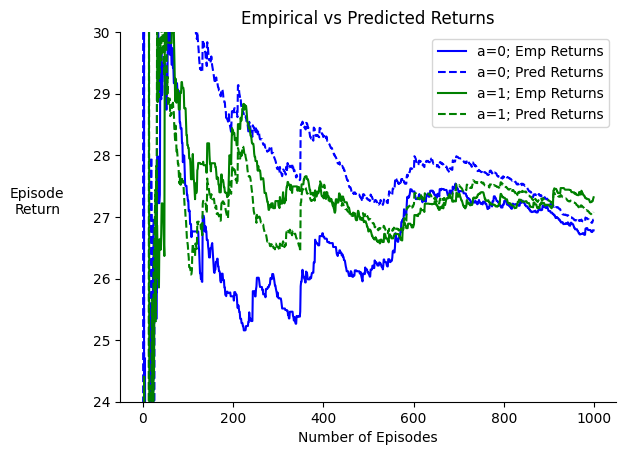

In [28]:

ax = plot_est_vs_pred([
      (average_returns_q[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='Empirical vs Predicted Returns',
   show=False)

ax.set_ylim(24, 30)
plt.show()


### Evaluate a more interesting policy (back-and-forth)

Simple control: if on one side, push the other way, if on other side, push back against it.

In [40]:

num_episodes = 100

# We record:
returns_per_episode_q_bf = np.zeros((2, num_episodes))
average_returns_q_bf = np.zeros((2, num_episodes))  # the cumulative average of the above
predicted_returns_q_bf = np.zeros((2, num_episodes))

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.identity(2 * d)   # An estimate of A = xx^T
targets = np.zeros(2 * d)  # An estimate of b = xG
weights = np.zeros(2 * d)   # The weights that approximate A^{-1} b

x_0 = phi.get_fourier_feature([0,0,0,0])  # the initial state
x_sa0 = phi_sa(x_0, 0)
x_sa1 = phi_sa(x_0, 1)

def policy(observation):
    if observation[2] < 0:
        return 0
    else:
        return 1

for episode in range(num_episodes):
    weights, targets, features, cur_avr_returns = ols_monte_carlo_q(
        env, phi, weights, targets, features, x_0, policy=policy)
    
    # Store the empirical and predicted returns. For any episode, we may
    # or may not have empirical returns for both actions. When we don't have an
    # estimate, `nan` is returned.
    returns_per_episode_q_bf[:, episode] = cur_avr_returns
    average_returns_q_bf[:, episode] = np.nanmean(returns_per_episode_q_bf[:, :episode+1], axis=1)

    predicted_returns_q_bf[0, episode] = np.inner(x_sa0.flatten(), weights)
    predicted_returns_q_bf[1, episode] = np.inner(x_sa1.flatten(), weights)
    print(
        'episode:', episode,
        ' empirical returns:' , average_returns_q_bf[:, episode],
        ' predicted returns:' , predicted_returns_q_bf[:, episode])

episode: 0  empirical returns: [-1.00000000e-07  5.01099066e+02]  predicted returns: [447.85634348 509.86518273]
episode: 1  empirical returns: [-1.00000000e-07  5.01099066e+02]  predicted returns: [443.1830954  507.69751787]
episode: 2  empirical returns: [-1.00000000e-07  5.01099066e+02]  predicted returns: [441.57371251 506.49228235]
episode: 3  empirical returns: [-1.00000000e-07  5.01099066e+02]  predicted returns: [440.62836365 505.75535484]
episode: 4  empirical returns: [-1.00000000e-07  5.01099066e+02]  predicted returns: [439.86952832 505.26383889]
episode: 5  empirical returns: [-1.00000000e-07  5.01099066e+02]  predicted returns: [439.17493813 504.91432981]
episode: 6  empirical returns: [-1.00000000e-07  5.01099066e+02]  predicted returns: [438.51027453 504.65343342]
episode: 7  empirical returns: [-1.00000000e-07  5.01099066e+02]  predicted returns: [437.86618237 504.45111023]
episode: 8  empirical returns: [-1.00000000e-07  5.01099066e+02]  predicted returns: [437.240637

KeyboardInterrupt: 

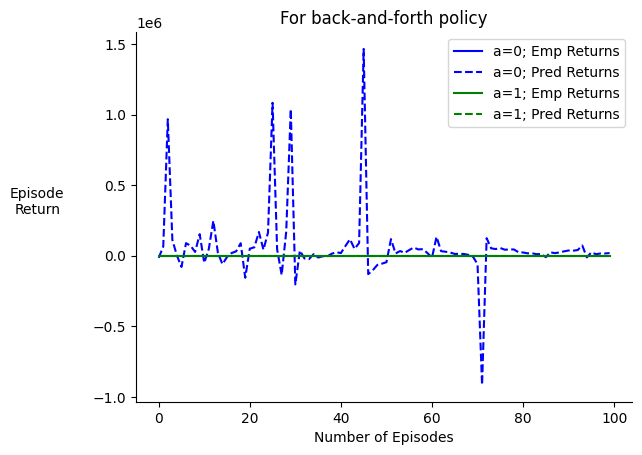

In [30]:

ax = plot_est_vs_pred([
      (average_returns_q_bf[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q_bf[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q_bf[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q_bf[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='For back-and-forth policy',
   show=False)

# ax.set_ylim(32, 33)
plt.show()

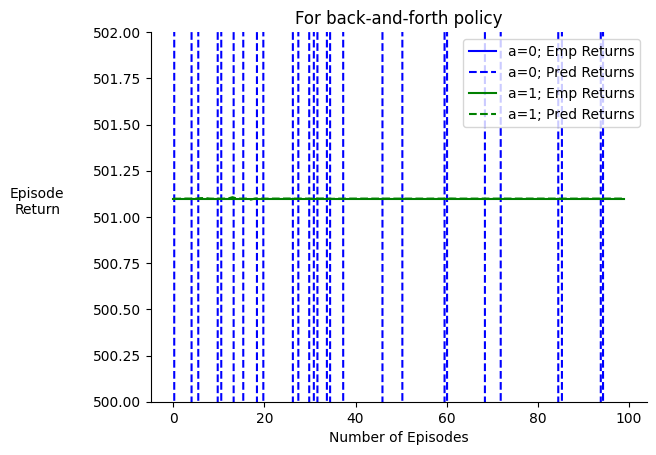

In [31]:

ax = plot_est_vs_pred([
      (average_returns_q_bf[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q_bf[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q_bf[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q_bf[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='For back-and-forth policy',
   show=False)

ax.set_ylim(500, 502)
plt.show()


## MC Control

The strategy is:

1. Initialize Q values with weight = 0; policy is always eps-greedy wrt Q.
2. Repeat until convergence (?):
3.      MC evaluation of current policy, updates Q-values

Note that this strategy implicitly uses 1 episode evaluation per each improvement step.
See Sutton & Barto p99, Monte-Carlo ES control, for a similar algorithm, one that uses
exploring starts instead of soft-policies for coverage.

Another possible variant: use temperature.

In [41]:

num_episodes = 500
epsilon = 0.1

# We record:
returns_per_episode_q = np.zeros((2, num_episodes))
average_returns_q = np.zeros((2, num_episodes))  # the cumulative average of the above
predicted_returns_q = np.zeros((2, num_episodes))

reset_randomness(seed, env)

observation, _ = env.reset()
d = len(phi.get_fourier_feature(observation))
assert d == phi.num_parameters
features = np.identity(2 * d)   # An estimate of A = xx^T
targets = np.zeros(2 * d)  # An estimate of b = xG
weights = np.zeros(2 * d)   # The weights that approximate A^{-1} b

x_0 = phi.get_fourier_feature([0,0,0,0])  # the initial state
x_sa0 = phi_sa(x_0, 0)
x_sa1 = phi_sa(x_0, 1)

for episode in range(num_episodes):
    def policy(state):
        if random.random() < epsilon:
            return env.action_space.sample()
        # Otherwise calculate the best action.
        x = phi.get_fourier_feature(state)
        qs = np.zeros(2)
        for action in [0, 1]:
            x_sa = phi_sa(x, action)
            qs[action] = np.inner(x_sa.flatten(), weights)
        # adaptive_time.utils.softmax(qs, 1)
        return adaptive_time.utils.argmax(qs)

    weights, targets, features, cur_avr_returns = ols_monte_carlo_q(
        env, phi, weights, targets, features, x_0, policy=policy, print_trajectory=False)
    
    # Store the empirical and predicted returns. For any episode, we may
    # or may not have empirical returns for both actions. When we don't have an
    # estimate, `nan` is returned.
    returns_per_episode_q[:, episode] = cur_avr_returns
    average_returns_q[:, episode] = np.nanmean(returns_per_episode_q[:, :episode+1], axis=1)

    predicted_returns_q[0, episode] = np.inner(x_sa0.flatten(), weights)
    predicted_returns_q[1, episode] = np.inner(x_sa1.flatten(), weights)
    print(
        'episode:', episode,
        ' empirical returns:' , returns_per_episode_q[:, episode],
        ' predicted returns:' , predicted_returns_q[:, episode])

episode: 0  empirical returns: [ 1.3909363e+01 -1.0000000e-06]  predicted returns: [ 1.37667605e+01 -5.48172618e-15]
episode: 1  empirical returns: [ 1.68646776e+01 -1.00000000e-06]  predicted returns: [15.31519148  5.08803829]
episode: 2  empirical returns: [ 1.68646776e+01 -1.00000000e-06]  predicted returns: [15.86664435  8.54330524]
episode: 3  empirical returns: [ 4.44726335e+02 -1.00000000e-06]  predicted returns: [138.52686846 115.15108039]
episode: 4  empirical returns: [ 4.23785726e+02 -1.00000000e-06]  predicted returns: [283.14311771 413.93775861]
episode: 5  empirical returns: [-1.00000000e-07  1.58805582e+01]  predicted returns: [267.743252   206.15364989]
episode: 6  empirical returns: [ 1.68140782e+02 -1.00000000e-06]  predicted returns: [229.37387466 155.62047451]
episode: 7  empirical returns: [ 7.41458162e+01 -1.00000000e-06]  predicted returns: [200.68218617 147.21603325]
episode: 8  empirical returns: [ 2.60773641e+02 -1.00000000e-06]  predicted returns: [208.393085

KeyboardInterrupt: 

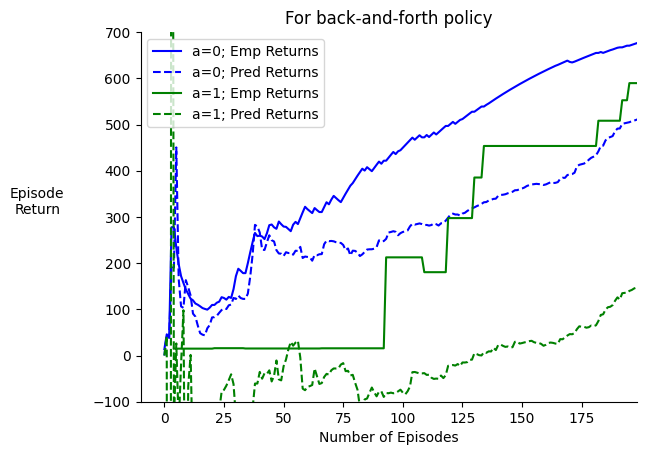

In [148]:

ax = plot_est_vs_pred([
      (average_returns_q[0], 'a=0; Emp Returns', dict(linestyle='-', color='blue')),
      (predicted_returns_q[0], 'a=0; Pred Returns', dict(linestyle='--', color='blue')),
      (average_returns_q[1], 'a=1; Emp Returns', dict(linestyle='-', color='green')),
      (predicted_returns_q[1], 'a=1; Pred Returns', dict(linestyle='--', color='green')),
   ],
   title='For back-and-forth policy',
   show=False)

ax.set_ylim(-100, 700)
ax.set_xlim(-10, 198)
plt.show()

In [139]:
def policy(state, weights, epsilon=0.1):
    if random.random() < epsilon:
        return env.action_space.sample()
    # Otherwise calculate the best action.
    x = phi.get_fourier_feature(state)
    qs = np.zeros(2)
    for action in [0, 1]:
        x_sa = phi_sa(x, action)
        qs[action] = np.inner(x_sa.flatten(), weights)
    # adaptive_time.utils.softmax(qs, 1)
    return adaptive_time.utils.argmax(qs)

traj = generate_trajectory(env, policy=lambda o: policy(o, weights=weights, epsilon=0.1))

In [140]:
len(traj)

2625

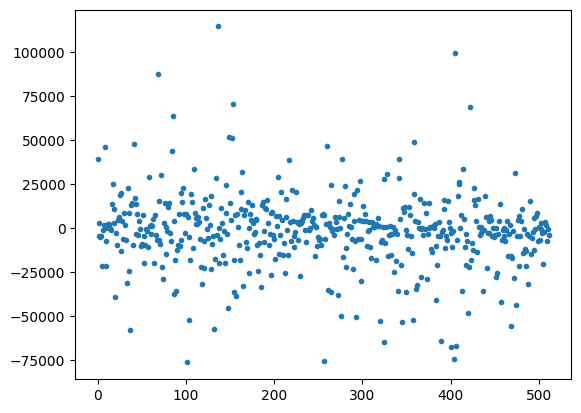

In [152]:
plt.plot(weights, '.')

(array([  9.,  14.,  51., 196., 194.,  31.,  11.,   3.,   1.,   2.]),
 array([-7.62428699e+04, -5.71669468e+04, -3.80910237e+04, -1.90151007e+04,
         6.08224116e+01,  1.91367455e+04,  3.82126686e+04,  5.72885916e+04,
         7.63645147e+04,  9.54404378e+04,  1.14516361e+05]),
 <BarContainer object of 10 artists>)

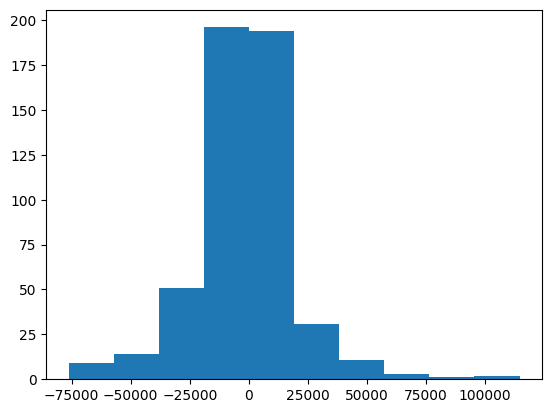

In [153]:
plt.hist(weights)

### Running for longer?

## Random Tests

In [73]:
testx = np.array([
    [1, 2, 3],
    [10, 20, 30]
])
print(testx)

print(testx.flatten())

[[ 1  2  3]
 [10 20 30]]
[ 1  2  3 10 20 30]


In [74]:
testy = np.array([
    [1, 0, 0],
    [np.nan, 0, 0]
])

ep = 1
testy[:, ep] = (np.nan, 20)  
print(testy)
print(np.nanmean(testy[:, :ep+1], axis=1))



[[ 1. nan  0.]
 [nan 20.  0.]]
[ 1. 20.]


In [75]:
a = testx
a.fill(0)
print(a)
print(testx)

[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]


In [76]:
if np.mean([]):
    print("mean exists")
else:
    print("mean does not exist")

mean exists


In [77]:
testx[:, 0] = (0, 0)
print(testx)

[[0 0 0]
 [0 0 0]]


In [78]:
trajectory

[[array([0., 0., 0., 0.], dtype=float32),
  1,
  1.0,
  array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32)],
 [array([ 0.        ,  0.19512194,  0.        , -0.29268292], dtype=float32),
  1,
  1.0,
  array([ 0.00390244,  0.3902439 , -0.00585366, -0.58536583], dtype=float32)],
 [array([ 0.00390244,  0.3902439 , -0.00585366, -0.58536583], dtype=float32),
  1,
  1.0,
  array([ 0.01170732,  0.5854474 , -0.01756098, -0.879887  ], dtype=float32)],
 [array([ 0.01170732,  0.5854474 , -0.01756098, -0.879887  ], dtype=float32),
  1,
  1.0,
  array([ 0.02341626,  0.78080344, -0.03515872, -1.        ], dtype=float32)],
 [array([ 0.02341626,  0.78080344, -0.03515872, -1.        ], dtype=float32),
  0,
  1.0,
  array([ 0.03903233,  0.5861686 , -0.05515872, -0.7185627 ], dtype=float32)],
 [array([ 0.03903233,  0.5861686 , -0.05515872, -0.7185627 ], dtype=float32),
  1,
  1.0,
  array([ 0.05075571,  0.78200865, -0.06952997, -1.        ], dtype=float32)],
 [array([ 0.05075571, 